In [38]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas


In [353]:
def seq2seq(feature_len, after_day, input_shape):

    # Encoder
    encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    encoder = LSTM(units=256, return_state=True,  name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 256), name='reshapor')
    decoder = LSTM(units=256, return_sequences=True, return_state=True, name='decoder')

    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=feature_len, activation='linear', name='output')

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []

    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: backend.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [354]:
def normalize_data(data, scaler):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data,minmaxscaler

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

def normalize(df):
    min_max_scaler = MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]

In [487]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def buildTrain(train, pastDay=30, futureDay=5,feature='close',drop=False):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(train[i+pastDay:i+pastDay+futureDay]))
        #Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][feature]))        
    return np.array(X_train), np.array(Y_train)
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
def plot_predict(data, data_predict):
    #file_path = 'images/result/{}.png'.format(file_name)

    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)

    ax1.plot(data[:, 0, 15],label='actual', color='blue')
    ax1.plot(data_predict[:, 6, 15],label='predict', color='red')
    ax1.title.set_text("Day 1")
    ax1.legend(loc='best')

    ax2.plot(data[:, 1, 15], color='blue')
    ax2.plot(data_predict[:, 1, 15], color='red')
    ax2.title.set_text("Day 2")

    ax3.plot(data[:, 2, 15], color='blue')
    ax3.plot(data_predict[:, 2, 15], color='red')
    ax3.title.set_text("Day 3")

    ax4.plot(data[:, 3, 15], color='blue')
    ax4.plot(data_predict[:, 3, 15], color='red')
    ax4.title.set_text("Day 4")

    ax5.plot(data[:, 4, 15], color='blue')
    ax5.plot(data_predict[:, 4, 15], color='red')
    ax5.title.set_text("Day 5")

    #plt.savefig(file_path)

In [414]:
df = []
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
'''
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        print(train_data)
        
        sub_df=pickle.load(f)#.iloc[:-60]
        #print((sub_df.columns))
        #sub_df.replace([np.inf, -np.inf], np.nan,inplace=True)
        #print(sub_df.isna().sum())
        all_df.append(sub_df)

df = pd.concat(all_df,axis=0, ignore_index=True)
'''
df.shape

(3641, 29)

In [454]:
scaler = MinMaxScaler(feature_range=(0, 1))
validate_percent = 0.8
time_step = 30
after_day = 7
batch_size = 64
epochs = 100
val_ratio = 0.33
#sub_df = df[['high','close','low','open']]
sub_df=df.drop(['year','week','month','day','adj_close'],axis=1)
data,_ = normalize_data(sub_df.copy(), scaler)

In [490]:
x_train,y_train=buildTrain(data, time_step,after_day,drop=False)
X_train, Y_train, X_val, Y_val = splitData(x_train, y_train, val_ratio)
X_train, Y_train = shuffle(X_train, Y_train)

In [456]:
feature_len = X_train.shape[2]
input_shape = (time_step, feature_len)
model = seq2seq(feature_len, after_day, input_shape)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 30, 24)]     0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 256), (None, 287744      input_25[0][0]                   
__________________________________________________________________________________________________
reshapor (Reshape)              (None, 1, 256)       0           encoder[0][0]                    
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, 1, 256), (No 525312      reshapor[0][0]                   
                                                                 encoder[0][1]             

In [457]:
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1000, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
38/38 [==============================] - 5s 126ms/step - loss: 0.0830 - accuracy: 0.2668 - val_loss: 0.0401 - val_accuracy: 0.2977
Epoch 2/1000
38/38 [==============================] - 3s 75ms/step - loss: 0.0473 - accuracy: 0.3492 - val_loss: 0.0404 - val_accuracy: 0.3454
Epoch 3/1000
38/38 [==============================] - 3s 74ms/step - loss: 0.0469 - accuracy: 0.4019 - val_loss: 0.0368 - val_accuracy: 0.4169
Epoch 4/1000
38/38 [==============================] - 3s 75ms/step - loss: 0.0437 - accuracy: 0.4294 - val_loss: 0.0361 - val_accuracy: 0.4427
Epoch 5/1000
38/38 [==============================] - 3s 75ms/step - loss: 0.0425 - accuracy: 0.4370 - val_loss: 0.0346 - val_accuracy: 0.4528
Epoch 6/1000
38/38 [==============================] - 3s 75ms/step - loss: 0.0414 - accuracy: 0.4509 - val_loss: 0.0333 - val_accuracy: 0.4490
Epoch 7/1000
38/38 [==============================] - 3s 75ms/step - loss: 0.0414 - accuracy: 0.4558 - val_loss: 0.0350 - val_accuracy: 0.462

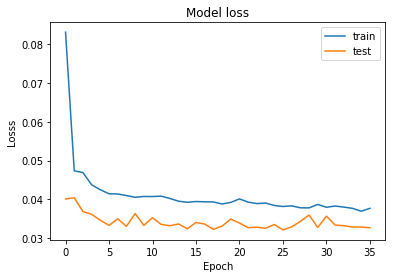

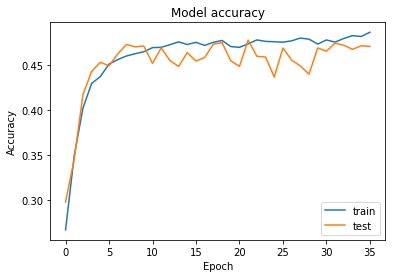

In [458]:
training_result(history)

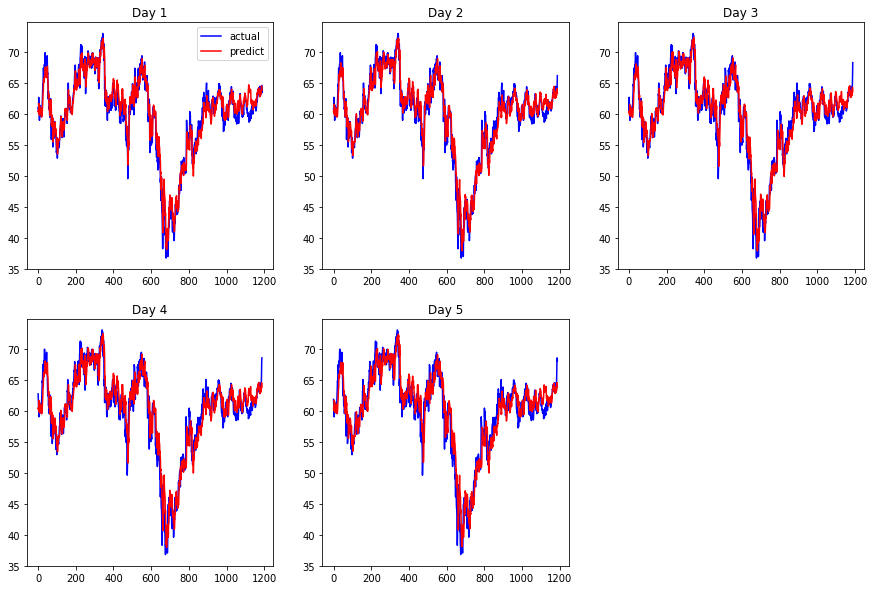

In [491]:
#with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
#    df = pickle.load(f)
#scaler = MinMaxScaler(feature_range=(0, 1))
#normalize_data(df.drop(['year','week','month','day','adj_close'],axis=1), scaler)
#x_train,y_train=buildTrain(sub_df.copy(), time_step,after_day,drop=False)
#_, _, _, Y_val = splitData(x_train, y_train, val_ratio)
train_predict = model.predict(X_val.copy())
#print(train_predict.shape)
result = inverse_normalize_data(train_predict.copy(), scaler)

actual = inverse_normalize_data(Y_val.copy(), scaler)
#actual = inverse_normalize_data(Y_val, scaler)
plot_predict(actual, result)

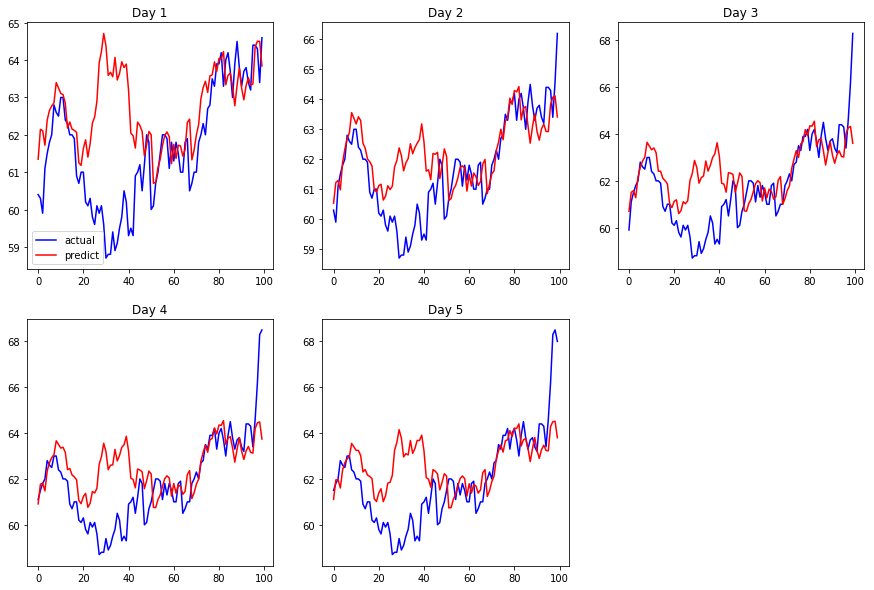

In [494]:
plot_predict(actual[-100:], result[-100:])